<a href="https://colab.research.google.com/github/anushageddam/FMML-ASSESSMENT./blob/main/Module_9_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [1]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2023-06-16 04:53:07--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.227.219.43, 13.227.219.81, 13.227.219.79, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.227.219.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  --.-KB/s    in 0.1s    

2023-06-16 04:53:07 (316 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


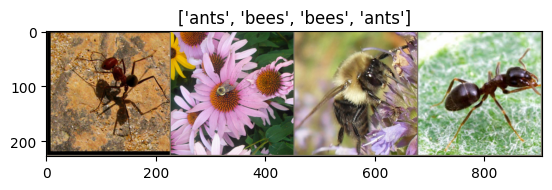

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [7]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 163MB/s] 


In [9]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.7854 Acc: 0.6557

Epoch 1/4
----------
Loss: 0.5556 Acc: 0.8033

Epoch 2/4
----------
Loss: 0.4917 Acc: 0.7746

Epoch 3/4
----------
Loss: 0.5144 Acc: 0.8074

Epoch 4/4
----------
Loss: 0.3744 Acc: 0.8689



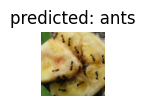

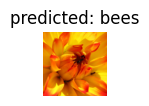

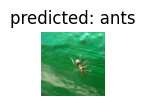

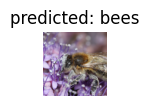

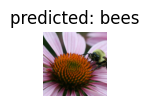

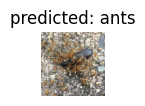

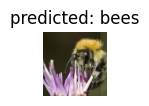

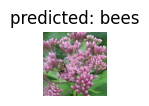

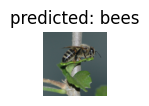

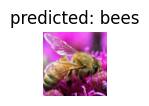

In [10]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?


**ANSWERS**

1].The significance of using data augmentations like resize, crop, and other techniques on training data can be summarized in the following points:

Increase in training data: Data augmentation techniques artificially expand the training dataset by generating new samples with minor variations from the original data. This is particularly valuable when the available training data is limited, as it helps to provide more diverse examples for the model to learn from. By increasing the amount of training data, data augmentations can potentially enhance the model's ability to generalize and perform well on unseen data.

Improved robustness to variations: Data augmentations introduce variations in the training data, such as different scales, rotations, translations, flips, or crops. By exposing the model to these variations during training, it becomes more robust and better equipped to handle such variations in real-world scenarios. For example, by augmenting an image dataset with random rotations, the model can learn to recognize objects from different viewpoints.

Regularization and generalization: Data augmentations act as a form of regularization, preventing overfitting and promoting generalization. By introducing noise or perturbations in the training data, data augmentations help the model to learn more robust and meaningful features, reducing its reliance on specific details or artifacts in the training set. This helps the model to generalize better to unseen data and improve its performance on test or validation sets.

Mitigation of bias: Data augmentations can also help mitigate biases in the training data. For example, if a dataset has a disproportionate representation of certain classes or certain patterns are more prevalent, data augmentations can balance the distribution and reduce biases. By applying random augmentations uniformly across different classes or samples, the model can be trained on a more balanced and representative dataset.

Adaptation to different input sizes or formats: Data augmentations like resizing or cropping can be particularly useful when the model needs to handle inputs of varying sizes or formats. By applying these augmentations, the training data can be transformed to match the expected input size or aspect ratio, allowing the model to learn how to process and extract features from inputs with different dimensions.

In summary, data augmentations are essential for training robust and generalized models. They increase the training data, introduce variations, improve the model's ability to handle diverse scenarios, regularize the learning process, mitigate biases, and adapt the model to different input sizes or formats.

2].If you don't use a pretrained ResNet model and train the model from scratch (pretrained=False), the performance of the model is likely to be lower compared to using a pretrained model. Training a deep neural network from scratch on a small dataset may result in overfitting and limited generalization capability.

Without the benefits of transfer learning from a pretrained model, the model would need to learn meaningful features entirely from the small dataset. This can be challenging, especially if the dataset is limited in size or lacks diversity. The model may struggle to capture complex patterns and variations, resulting in lower performance and higher chances of overfitting.

In contrast, using a pretrained ResNet model provides the advantage of leveraging knowledge learned from training on a large-scale dataset. The pretrained model has already learned a rich set of features that can be relevant to a wide range of visual recognition tasks. By fine-tuning the pretrained model on the target dataset, the model can adapt and specialize its learned features to the specific task, leading to improved performance and better generalization.

Therefore, not using a pretrained ResNet model and training from scratch may result in lower performance, slower convergence, and higher risk of overfitting, particularly when dealing with small datasets.

3].The performance of a pretrained ResNet model on the ants vs bees dataset would depend on the similarity between the pretraining dataset and the target dataset. If the pretraining dataset is significantly different from the ants vs bees data, the performance of the pretrained model may not be as good as expected.

When a pretrained model is used, it relies on the knowledge and features it has learned from the pretraining dataset. If the pretraining dataset is unrelated or significantly different from the target dataset, the pretrained model may not have learned features that are relevant or specific to the new dataset. As a result, the performance of the pretrained model on the target dataset may be limited.

In the case of ants vs bees data, the pretrained ResNet model might have learned general visual features from a different dataset (e.g., ImageNet) that may not directly translate to the distinguishing features of ants and bees. However, the lower layers of the network might still capture general low-level features like edges, corners, and textures, which can be somewhat transferable.

To improve the performance of a pretrained model on a significantly different dataset like ants vs bees, it is common to perform fine-tuning. Fine-tuning involves taking the pretrained model and further training it on the target dataset. By allowing the model to adapt its learned features to the specific characteristics of the target dataset, it can improve its performance on the new task. This fine-tuning process adjusts the weights of the pretrained model while training on the new dataset, thereby enabling it to learn more specific features related to ants and bees.

In summary, while a pretrained ResNet model may not achieve optimal performance on a significantly different dataset like ants vs bees, it can still provide a good starting point. Fine-tuning the pretrained model on the target dataset is often necessary to adapt its learned features and improve its performance on the specific task.




